# Floating Wind & Marine, and Emissions

## Overview

In this notebook, floating wind, wave power, tidal stream and tidal lagoon are considered specifically.  After the optimisation, the greenhouse gas emissions of the period under consideration are calculated for the whole grid, and for each node.

The emissions calculation relies on emissions intensity factors for each type of generation - due to the signficant differences between certain types within a carrier.  This input data is provided from literature review.

## Setup

### Environments and Modules

In [1]:
import os
from dotenv import find_dotenv, load_dotenv

load_dotenv(find_dotenv())
src_path = os.environ.get('PROJECT_SRC')
os.chdir(src_path)

In [2]:
import pypsa
import matplotlib.pyplot as plt
import pandas as pd
import cartopy.crs as ccrs
import string
import numpy as np

import data_reader_writer
import generators

### Defining the Simulation Period

Set the required inputs for the LOPF: the start, end and year of simulation, and the timestep.

In [3]:
# write csv files for import
start = '2050-02-27 00:00:00'
end = '2050-03-01 23:30:00'
# year of simulation
year = int(start[0:4])
# time step as fraction of hour (default set to one hour to reduce computation)
time_step = 1.0

### Selecting the Future Energy Scenario

Choose from one of the National Grid Future Energy Scenarios.

In [4]:
# scenario = 'Consumer Transformation'
scenario = 'Leading The Way'
# scenario = 'Steady Progression'
# scenario = 'System Transformation'

Choose a baseline year (from 2010-2020). The baseline year determines which historical load profile and weather dataset is used for the future year modelled. The National Grid FES modellers used 2012 as their baseline year.

In [5]:
year_baseline = 2012

The parameters "marine_modify" is set to True, and the marine_scenario is chosen here as "High" (options are "Low", "Mid", "High")

In [7]:
data_reader_writer.data_writer(start, end, time_step, year, demand_dataset='eload', year_baseline=year_baseline,
                               scenario=scenario, FES=2022, scale_to_peak=True, #merge_generators=True,
                               networkmodel='Reduced', P2G=True, 
                               floating_wind_scenario='Mid', wave_scenario='Mid', tidal_stream_scenario='Mid')

c:\Users\alyden\Anaconda3\envs\PyPSA-GB\lib\site-packages\pandas\core\arrays\datetimes.py:741: PerformanceWarning: Non-vectorized DateOffset being applied to Series or DatetimeIndex
  warnings.warn(
c:\Users\alyden\Anaconda3\envs\PyPSA-GB\lib\site-packages\pandas\core\indexing.py:1667: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = value
C:\Users\alyden\OneDrive - University of Edinburgh\Python\PyPSA-GB v0.0.1\PyPSA-GB\interconnectors.py:207: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  df_FES = df_FES[~df_FES.Variable.str.contains('(TWh)')]


## Running the Optimisation

In [8]:
network = pypsa.Network()
network.import_from_csv_folder('LOPF_data')

Importing PyPSA from older version of PyPSA than current version.
Please read the release notes at https://pypsa.readthedocs.io/en/latest/release_notes.html
carefully to prepare your network for import.
Currently used PyPSA version [0, 20, 1], imported network file PyPSA version None.

INFO:pypsa.components:Applying weightings to all columns of `snapshot_weightings`
       'Fai-Hea', 'Hol', 'NE-Jer', 'Nor-Ron-Fir', 'Pen-Fir-Dee', 'Pen-Fir-Sha',
       'Rai-Isl', 'Ram-Isl', 'Sou-Jer', 'Sou-Min-Jer', 'Str-Lou', 'Tor-Hea',
       'Wes-Ang-Dem-Mor', 'Wes-Cas', 'Wes-Fir'],
      dtype='object', name='Generator') for attribute p_max_pu of Generator are not in main components dataframe generators
INFO:pypsa.io:Imported network LOPF_data has buses, generators, lines, links, loads, storage_units


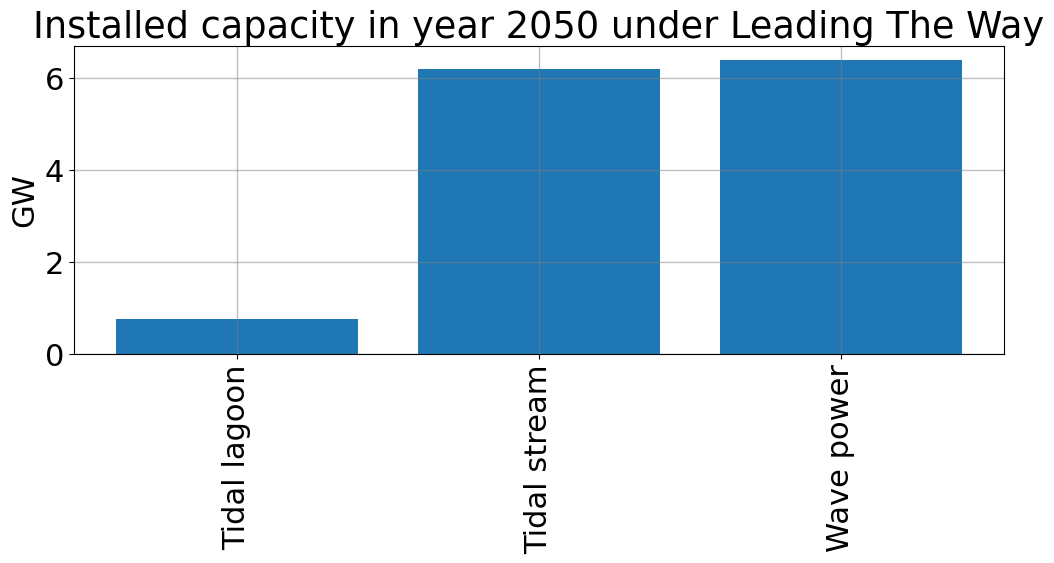

carrier
Oil                        0.000000
Natural Gas                0.000000
Coal                       0.000000
Biomass (co-firing)       54.400000
Small Hydro              255.660881
Tidal lagoon             749.000000
Waste                    891.066000
Large Hydro             1951.059135
CCS Biomass             2799.999982
Biomass (dedicated)     3136.960000
CCS Gas                 4210.000001
Tidal stream            6210.000000
Wave power              6390.000000
Nuclear                 8120.000000
Hydrogen               17576.340000
Wind Onshore           44774.700000
Wind Offshore          89057.570000
Solar Photovoltaics    91806.650000
Name: p_nom, dtype: float64

In [9]:
df_generators = network.generators
generators_p_nom = df_generators.p_nom.groupby(
    df_generators.carrier).sum().sort_values()
if year > 2020:
    generators_p_nom.drop('Unmet Load', inplace=True)
marine = generators_p_nom.loc[['Tidal lagoon', 'Tidal stream', 'Wave power']]

plt.rcParams.update({'font.size': 22})
# bar chart
plt.figure(figsize=(12,4))
plt.bar(marine.index, marine.values / 1000)
plt.xticks(marine.index, rotation=90)
plt.ylabel('GW')
plt.grid(color='grey', linewidth=1, axis='both', alpha=0.5)
plt.title('Installed capacity in year ' + str(year) + ' under ' + scenario)
plt.show()
generators_p_nom

In [10]:
print(marine)

carrier
Tidal lagoon     749.0
Tidal stream    6210.0
Wave power      6390.0
Name: p_nom, dtype: float64


Lines need to be scaled up to accommodate for future generation. An arbitrary value of 4 is selected.

In [11]:
contingency_factor = 4
network.lines.s_max_pu *= contingency_factor

In [12]:
network.lopf(network.snapshots, solver_name="gurobi", pyomo=False)

INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 3.45s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Set parameter Username

--------------------------------------------
--------------------------------------------

Academic license - for non-commercial use only - expires 2023-10-19
Read LP format model from file C:\Users\alyden\AppData\Local\Temp\pypsa-problem-t1m2udw4.lp
Reading time = 1.85 seconds
obj: 795096 rows, 212905 columns, 1391856 nonzeros
Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (win64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 795096 rows, 212905 columns and 1391856 nonzeros
Model fingerprint: 0x85173275
Coefficient statistics:
  Matrix range     [6e-05, 1e+00]
  Objective range  [1e+00, 1e+09]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-06, 6e+12]
         Consider reformulating model or setting NumericFocus parameter
         to avoid numerical issues.

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve removed 782646 rows and 173358 columns
Presolve time: 0.6

INFO:pypsa.linopf:Optimization successful. Objective value: -6.67e+06


('ok', 'optimal')

## Results

### Power by Generation Type

Real power output is interrogated by generation type.  The total contribution to the grid wide generation is reported over the simulation period.  Nodal contributions are analysed in the emissions modelling section.

Note that there is a difference in terminology between generators and storage types; it is storage carriers that are plotted, however they are described as storage 'types'.

In [13]:
# define dataframe containing time series of real power generated, arranged by generation and storage types
p_by_type = network.generators_t.p.groupby(network.generators.type, axis=1).sum()

# Combining Hydro types into a single category and removing 
p_by_type['Hydro'] = (p_by_type['Small Hydro'] + p_by_type['Large Hydro'])

p_by_type.drop('Small Hydro', axis=1, inplace=True)
p_by_type.drop('Large Hydro', axis=1, inplace=True)

# Combining Diesel/Gas oil types into a single category and removing 
p_by_type['Diesel'] = (p_by_type['Diesel/Gas oil'] + p_by_type['Diesel/gas Diesel/Gas oil'])

p_by_type.drop('Diesel/Gas oil', axis=1, inplace=True)
p_by_type.drop('Diesel/gas Diesel/Gas oil', axis=1, inplace=True)


# Combining Nuclear types into a single category and removing 
p_by_type['Nuclear'] = (p_by_type['AGR'] + p_by_type['PWR'])

p_by_type.drop('AGR', axis=1, inplace=True)
p_by_type.drop('PWR', axis=1, inplace=True)

# Sorting generation types alphabetically
p_by_type = p_by_type[sorted(p_by_type.columns)]

# concatenating storage types
storage_by_type = network.storage_units_t.p.groupby(network.storage_units.carrier, axis=1).sum()
p_by_type = pd.concat([p_by_type, storage_by_type], axis=1)
p_by_type.drop('P2G', axis=1, inplace=True)

# Including Interconnectors Import
imp = network.links_t.p0.copy()
imp[imp < 0] = 0
imp['Interconnectors Import'] = imp.sum(axis=1)
interconnector_import = imp[['Interconnectors Import']]
p_by_type = pd.concat([p_by_type, interconnector_import], axis=1)

# Including Interconnectors Export (note that post-processing occurs later in script)
exp = network.links_t.p0.copy()
exp[exp > 0] = 0
exp['Interconnectors Export'] = exp.sum(axis=1)
interconnector_export = exp[['Interconnectors Export']]

# Renaming Interconnector Import
p_by_type = p_by_type.rename(columns={'Interconnector': 'Interconnectors Import'})

In [14]:
# Removing columns where generation is zero
p_by_type = p_by_type.loc[:, p_by_type.any()]

In [15]:
# Setting all negative generation values to zero
p_by_type[p_by_type < 0] = 0 # ideally stacked area chart would show all generation and charging
p_by_type

,Floating Wind,Floating wind,Hydro,Solar Photovoltaics,Tidal lagoon,Tidal stream,Wave power,Wind Offshore,Wind Onshore,Battery,Compressed Air,Liquid Air,Pumped Storage Hydroelectric,Interconnectors Import
snapshot,,,,,,,,,,,,,,
2050-02-27 00:00:00,0.000000,69986.995700,310.121345,0.0,0.000000,3921.447816,759.23073,63.777891,15519.542239,1882.754614,0.000000,0.000000,0.000000,7480.0
2050-02-27 01:00:00,0.000000,67779.623878,298.024594,0.0,9.743333,1959.353389,910.91790,64.890085,18211.085298,1477.870092,0.000000,0.000000,0.000000,6460.0
2050-02-27 02:00:00,23.466889,66565.382496,344.755340,0.0,176.361167,359.531523,360.08413,66.411006,20582.155915,528.027296,0.000000,0.000000,0.000000,6460.0
2050-02-27 03:00:00,0.000000,70075.831322,330.611955,0.0,613.563556,380.523302,580.85676,66.884595,18177.047391,1554.431495,0.000000,0.000000,0.000000,6460.0
2050-02-27 04:00:00,0.000000,69928.049142,274.253140,0.0,126.037889,3121.129456,402.54362,64.993005,15265.720711,0.000000,0.000000,0.000000,634.952757,6460.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2050-03-01 19:00:00,3.028498,72122.687287,799.175243,0.0,0.000000,2128.939917,545.90952,10.313571,3660.429756,10338.915718,2147.803387,1164.563494,2477.960271,6460.0
2050-03-01 20:00:00,5.599488,72080.488553,793.888134,0.0,7.536138,2948.480255,591.37252,10.851067,3459.975167,5274.748322,1532.253686,1671.219656,2003.356218,6460.0
2050-03-01 21:00:00,4.316515,71971.745207,706.944635,0.0,3.842111,1821.959767,856.89065,9.704073,2720.403208,1010.598716,75.614402,940.369335,3001.416948,6460.0


In [16]:
# Define colors for each generation/storage/interconnector type (note that Interconnector Export colour not defined in this way)

colors = {'Anaerobic Digestion': 'darkgoldenrod',
          'Biomass (co-firing)': 'yellowgreen',
          'Biomass (dedicated)': 'olivedrab',
          'CCGT': 'red',
          'CCS Biomass': 'darkolivegreen',
          'CCS Gas': 'lightcoral',
          'Diesel': 'lightgrey',
          'EfW Incineration': 'chocolate',
          'Floating wind': 'royalblue',
          'Floating Wind': 'royalblue',
          'Hydro': 'teal',
          'Hydrogen': 'paleturquoise',
          'Landfill Gas': 'olive',
          'Nuclear': 'lime',
          'OCGT': 'red',
          'Sewage Sludge Digestion': 'saddlebrown',
          'Solar Photovoltaics': 'yellow',
          'Tidal lagoon': 'mediumblue',
          'Tidal stream': 'midnightblue',
          'Unmet Load': 'black',
          'Wave power': 'steelblue',
          'Wind Offshore': 'cornflowerblue',
          'Wind Onshore': 'mediumseagreen',
          'Battery': 'mediumorchid',
          'Compressed Air': 'plum',
          'Liquid Air': 'thistle',
          'Pumped Storage Hydroelectric': 'deepskyblue',
          'Interconnectors Import': 'palevioletred',
          'P2G': 'black'
         }

#           'Coal': 'dimgrey',
#           'Oil': 'red',
#           'Biomass': 'greenyellow',       
#           'Interconnectors Export': 'crimson',          
#           'Sour gas': 'darkred',
#           'Natural Gas': 'coral',
#           'Large Hydro': 'darkturquoise',
#           'Small Hydro': 'turquoise',

c:\Users\alyden\Anaconda3\envs\PyPSA-GB\lib\site-packages\pandas\plotting\_matplotlib\core.py:1391: UserWarning: Attempting to set identical bottom == top == 0.0 results in singular transformations; automatically expanding.
  ax.set_ylim(None, 0)


Text(0.5, 0, '')

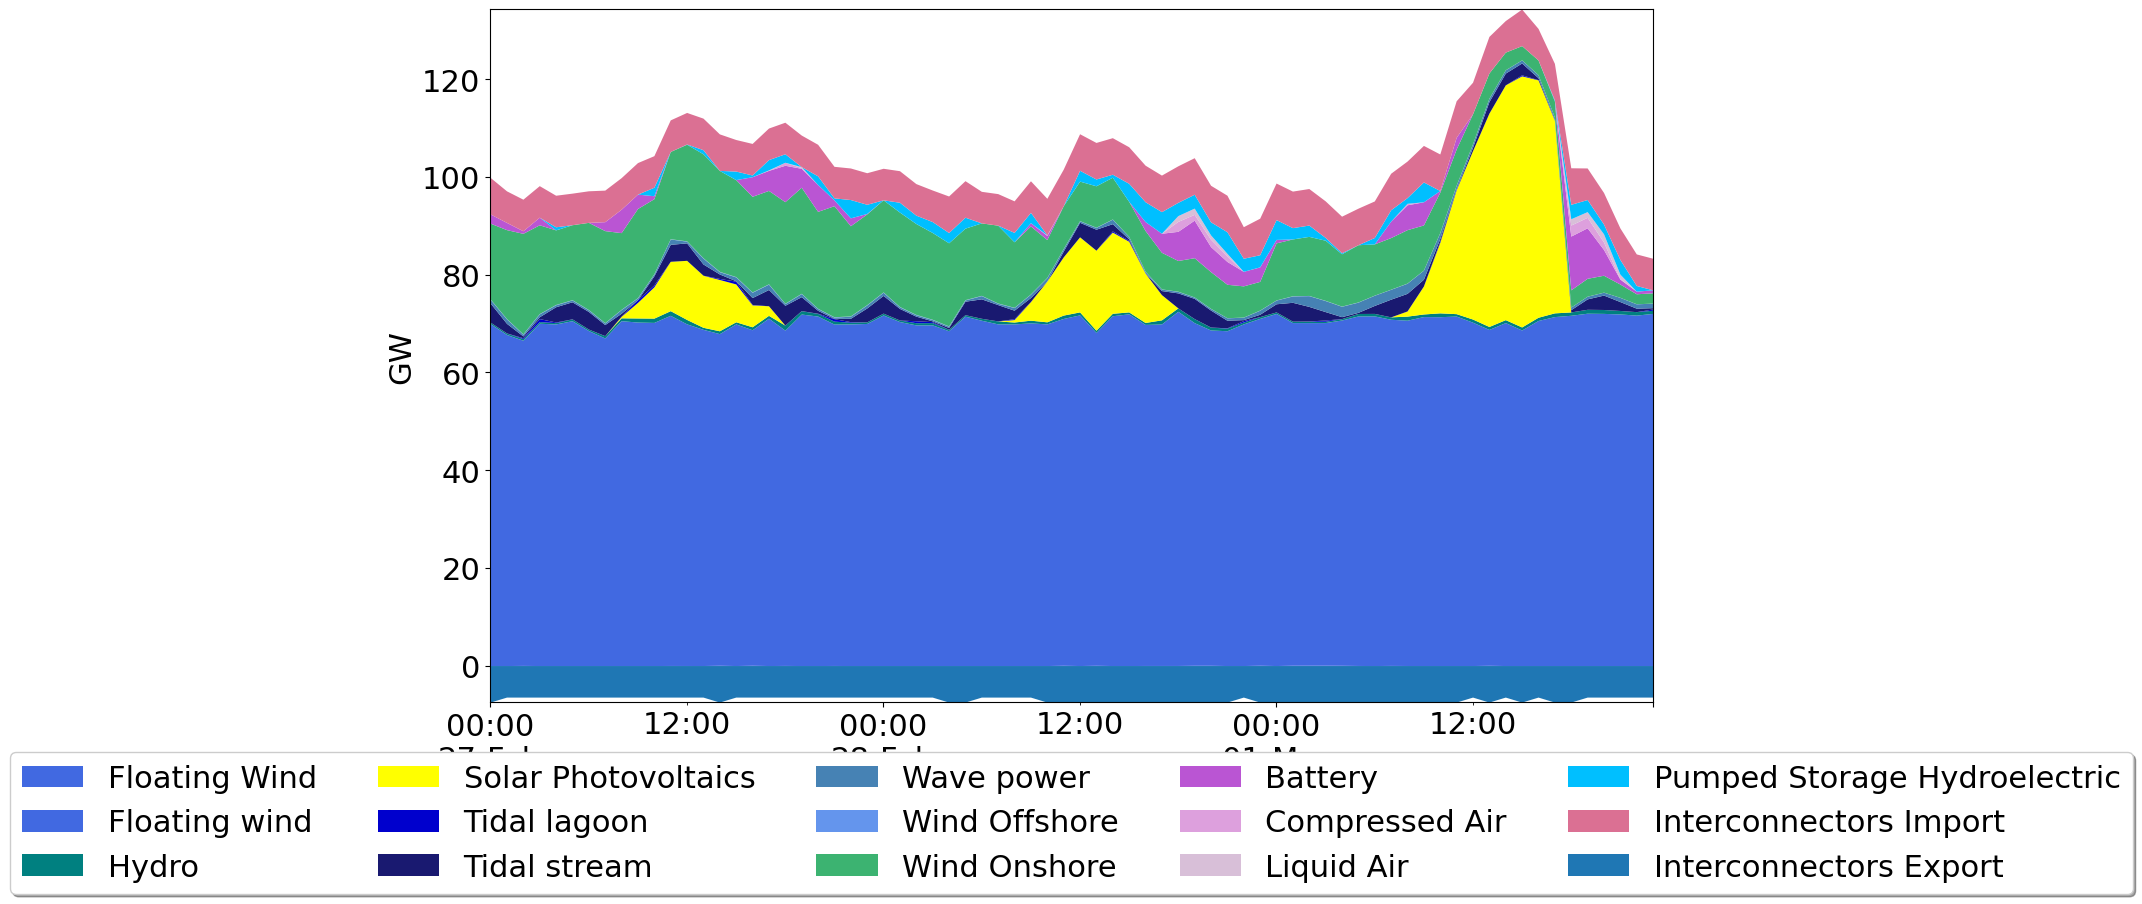

In [17]:
# Plot network-wide generation time series by generation type
fig, ax = plt.subplots(1, 1)
fig.set_size_inches(15,10)
(p_by_type / 1e3).plot(
    kind='area', ax=ax, linewidth=0,
    color=[colors[col] for col in p_by_type.columns])

# stacked area plot of negative values, prepend column names with '_' such that they don't appear in the legend
(interconnector_export / 1e3).plot.area(ax=ax, stacked=True, linewidth=0.)

# rescale the y axis
ax.set_ylim([(interconnector_export / 1e3).sum(axis=1).min(), (p_by_type / 1e3).sum(axis=1).max()])

# Shrink current axis's height by 10% on the bottom
box = ax.get_position()
ax.set_position([box.x0, box.y0 + box.height * 0.1,
                 box.width, box.height * 0.9])

# Put a legend below current axis
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05),
          fancybox=True, shadow=True, ncol=5)
ax.set_ylabel('GW')
ax.set_xlabel('')

### Emissions by Generation Type (including Interconnectors)

This section calculates a time series of emissions from each generation type according to the real power time series calculated in the previous section.  Note that these data include the emissions from interconnection, which is an important consideration - whether gross emissions from GB power sector include continental emissions.

In [18]:
 # arrange p_by_type columns into alphabetical order to ensure consistency with EI factors
p_by_type = p_by_type[sorted(p_by_type.columns)]

# create a numpy array from a list of generation types, from top row of generation mix dataframe
types = np.asarray(list(p_by_type.columns.values))

# reading in the emissions intensity data contained in relevant .csv as a dataframe
emissions_intensity = pd.read_csv('../data/emissions_intensity_by_types.csv')
emissions_intensity_LOPF = emissions_intensity[emissions_intensity['Type'].isin(types)]
emissions_intensity_LOPF.sort_values('Type')
EI_factors = emissions_intensity_LOPF['Emissions Intensity [gCO2/kWh]'].to_numpy()

# Create energy generation mix dataframe by multiplying power generation mix by the time step [MWh]
E_by_type = p_by_type.multiply(time_step)

# Create emissions dataframe. Multiply all columns in the energy dataframe by the numpy array of emissions intensity factors
Emit_by_type = E_by_type.multiply(EI_factors, axis=1)

# Convert gCO2/kWh * MWh to teCO2; the quotient of kWh:MWh (1e3) and gCO2:teCO2 (1e6) = 1e3
Emit_by_type_te = Emit_by_type.div(1e3)
Emit_by_type_te = Emit_by_type_te.loc[:, Emit_by_type_te.any()]

ValueError: Unable to coerce to Series, length must be 14: given 13

Text(0.5, 0, '')

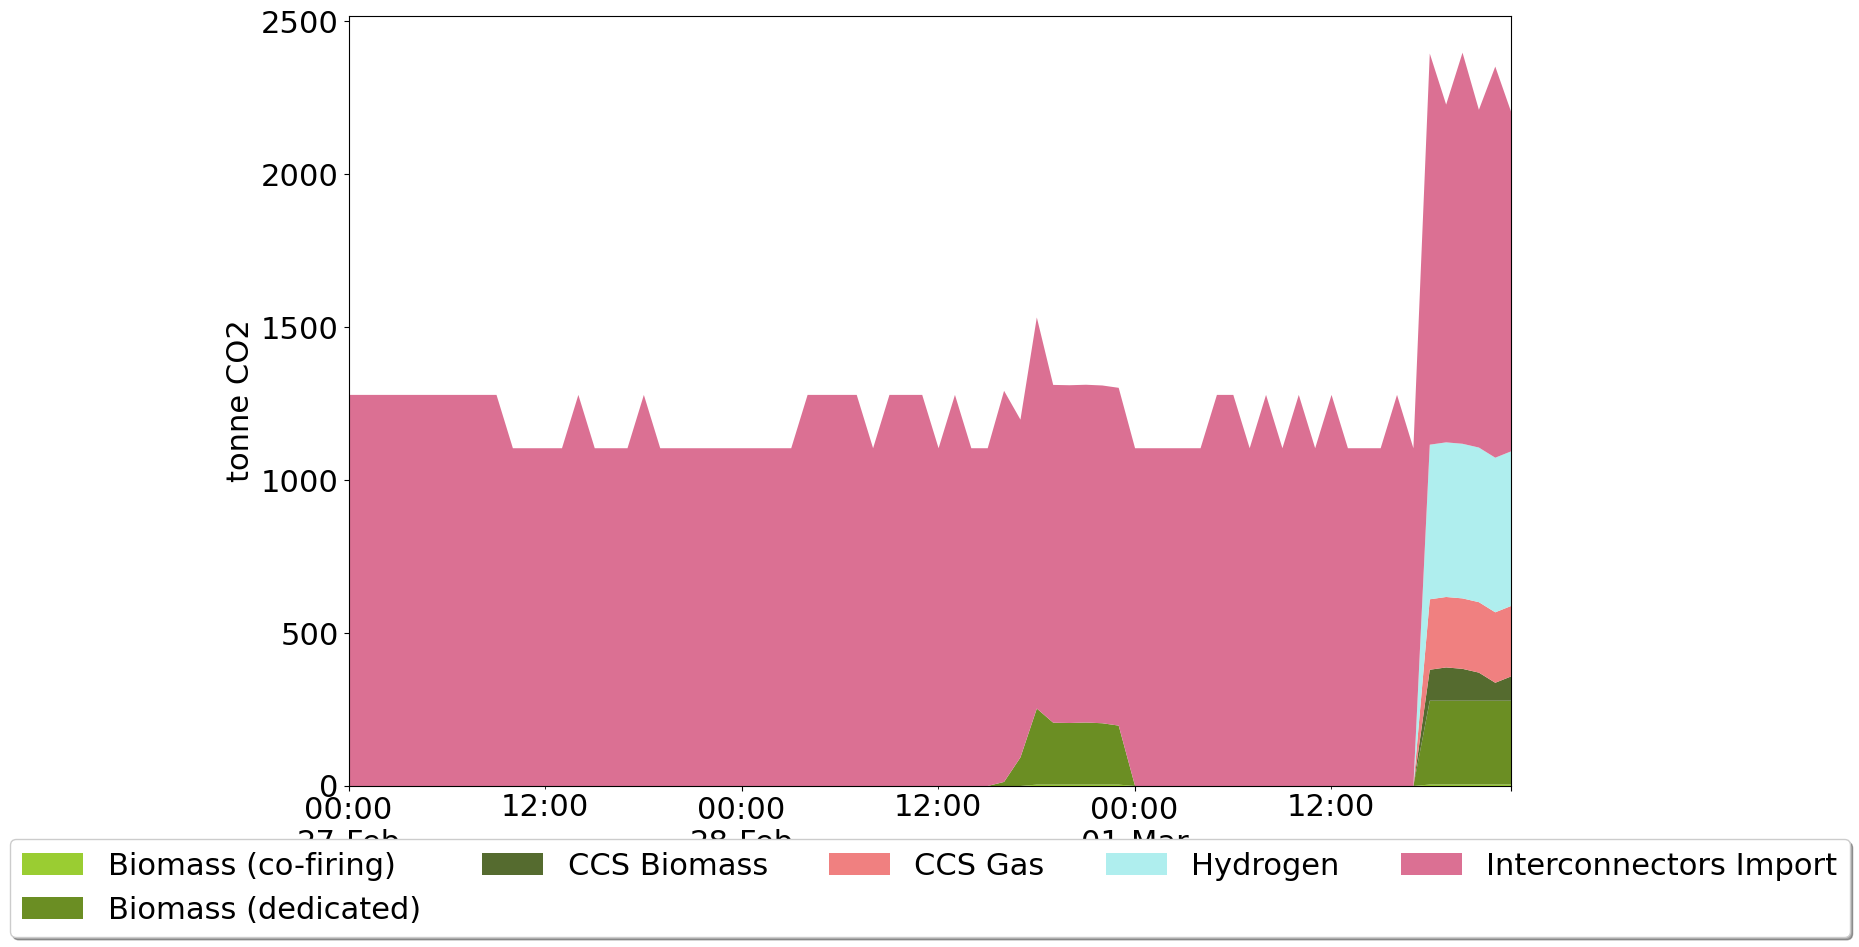

In [ ]:
fig, ax = plt.subplots(1, 1)
fig.set_size_inches(15,10)
(Emit_by_type_te).plot(
    kind="area", ax=ax, linewidth=0,
    color=[colors[col] for col in Emit_by_type_te.columns])

ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05),
          fancybox=True, shadow=True, ncol=5)

ax.set_ylabel("tonne CO2")
ax.set_xlabel("")

### Emissions Intensity (including Interconnectors)

A time series of the network-wide (including continental interconnectors) emissions intensity is determined below.  This is repeated later in the notebook, but excludes interconnectors.

In [ ]:
# Time series of total emissions in tonnes (sum of emissions from all types - including interconnectors unless explicitly modified)
Total_Emit_t_te = Emit_by_type_te.sum(axis=1)

# Energy delivered to the grid at each time step
Total_E_t = E_by_type.sum(axis=1)

# The grid-wide emissions intensity in gCO2/kWh at each time step is given by:
EI_gCO2 = Total_Emit_t_te * 1e3 / Total_E_t

#### Average Emissions Intensity (including Interconnectors)

In [ ]:
# Average emissions intensity over the period, method 1 = quotient of sums:
EI_avg_gCO2 = 1e3 * sum(Total_Emit_t_te) / sum(Total_E_t)
print("Average emissions intensity over the period, Method 1 = ", EI_avg_gCO2, "gCO2/kWh")

# Average emissions intensity over the period, method 2 = mean of dataframe:
print("Average emissions intensity over the period, Method 2 = ", EI_gCO2.mean(), "gCO2/kWh")

Average emissions intensity over the period, Method 1 =  14.295633013736277 gCO2/kWh
Average emissions intensity over the period, Method 2 =  14.783137298565755 gCO2/kWh
